In [43]:
import pandas as pd
import numpy as np
import time

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objs as go
from plotly.offline import iplot

---
### Sub：Metrics

In [45]:
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def calcError(origin, forecast):
    print("RMSE", RMSE(origin, forecast))
    print("MAPE", MAPE(origin, forecast))

In [46]:
def showPlot(true, prediction, model , test_set, size='M', save=False):
    if(size=='L'):
        plt.figure(figsize=(28, 10))
    plt.plot(true, color = 'red', label = 'Real')
    plt.plot(prediction, color = 'blue', label = 'Prediction')
    plt.title('Industry Elec Prediction' + model + ' ' + test_set + ' t' + str(t))
    plt.xlabel('Time')
    plt.ylabel('kW')
    plt.legend()
    if(save):
        plt.savefig('Image/' + model + '-' + test_set + '-' + str(t) + '.png')
    plt.show()

---
### Sub：Data

In [47]:
# 20160101~20161231 [0~366]
# 20170101~20171231 [366~731]
# 20180101~20181231 [731~1095]
# 20190101~20190930 [1096~1368]
# df = pd.read_csv('Data/elec_merge_20160101_20190930.csv')
df = pd.read_csv('Data/industryElec_processed_20160101_20190930.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.shape

(1369, 12)

In [48]:
df.head()

,Date,kW,PeakLoad(MW),isHoliday,week,week_update,dayOfYear,Temp_Taipei,PeakLoad(MW)_shift7,isHoliday_shift7,weekUpdate_shift7,Temp_Taipei_shift7
0,2016-01-01,263.799,23038,1.0,5,7,1,14.6,26400.0,0.0,5.0,12.0
1,2016-01-02,261.975,23209,1.0,6,6,2,15.7,24308.0,1.0,6.0,12.1
2,2016-01-03,266.167,23686,1.0,7,7,3,16.0,23490.0,1.0,7.0,16.2
3,2016-01-04,302.227,27518,0.0,1,1,4,17.7,27207.0,0.0,1.0,13.5
4,2016-01-05,313.328,27635,0.0,2,2,5,17.8,26747.0,0.0,2.0,11.4


In [49]:
# 資料維度擷取
def augFeatures(data, features_select):
    data = pd.DataFrame(data[features_select])
    data.shape
    return data

In [50]:
from sklearn.preprocessing import MinMaxScaler
def normalize(data):
    sc = MinMaxScaler(feature_range = (0, 1))
    data_scaled = pd.DataFrame(sc.fit_transform(data))
    return sc, data_scaled 

def deNormalize(sc, value):
    value_unscaled = value * (sc.data_max_[0]-sc.data_min_[0]) + sc.data_min_[0]
    return value_unscaled 

In [51]:
# 根據給定的時間範圍自動產生訓練、測試資料集
def split_dataset(data, pastDay=7, futureDay=7):
    split_num_start = df[df['Date'] == trainFrom].index.item()
    split_num = df[df['Date'] == testFrom].index.item()
    split_num_end = df[df['Date'] == testTo].index.item()
    print("split_num_start", split_num_start)
    print("split_num", split_num)
    print("split_num_end", split_num_end)
    if((split_num_end-split_num)%futureDay):
        print("Data range error.")
    split_num_end = split_num_end - ((split_num_end-split_num+1)%futureDay)
    split_num_end = split_num_end - ((split_num_end-split_num+1)%futureDay)
    
    # 訓練資料
    RawTrain = data[split_num_start:split_num]
    # 自我測試集
    SelfTest = data[split_num_start:split_num - futureDay]
    SelfTruth = data[split_num_start + pastDay:split_num][0]
    # 實際預測集
    RawTest = data[split_num - pastDay:split_num_end + 1 - futureDay]
    RawTrurh = data[split_num:split_num_end + 1][0]

    print("RawTrain", RawTrain.shape)
    print("RawTest, RawTrurh", RawTest.shape, RawTrurh.shape)
    print("SelfTest, SelfTruth", SelfTest.shape, SelfTruth.shape)
    return RawTrain, RawTest, RawTrurh, SelfTest, SelfTruth

In [52]:
# 僅負責滾動資料
def buildTrain(train, pastDay=7, futureDay=7):
    X_train, Y_train = [], []
    for i in range(pastDay, len(train)-futureDay):
        X_train.append(train[i-pastDay:i])
        Y_train.append(train[i:i+futureDay, 0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)  
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    print('X_train.shape, Y_train.shape', X_train.shape, Y_train.shape)
    return X_train, Y_train

In [53]:
# 僅負責滾動資料
def buildTest(test, pastDay=7, futureDay=7):
    X_test = []
    for i in range(0, int(len(test)/futureDay)-(pastDay-futureDay)):
        X_test.append(test[futureDay*i:futureDay*i+pastDay])
    X_test = np.array(X_test)
    print('buildTest.shape', X_test.shape)
#     print('buildTest', X_test)

    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))  
    print('buildTest.shape', X_test.shape)
    return X_test

In [54]:
# 拆分訓練與驗證，需要手動切割時才使用
def splitData(X, Y, rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val

In [55]:
def forecast(model, input_data, shape):
    forecast_temp = model.predict(input_data)
    # Append Data
    forecast = []
    for i in range(forecast_temp.shape[0]):
        forecast= np.concatenate((forecast, forecast_temp[i]), axis=0)
    # Reshape
    forecast = np.reshape(forecast, (shape[0], shape[1]))
    print('Truth.shape, Forecast.shape', shape, forecast.shape)
    return forecast

---
### Sub：Model

In [56]:
# 關閉警告
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
# Import the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, Flatten, RepeatVector
from keras.layers import SimpleRNN, LSTM, CuDNNLSTM
from keras.layers import Dropout, BatchNormalization, Bidirectional
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [57]:
def buildModel(shape, train_x, train_y):
    epochs, batch_size = 1000, 32
    # batch_size = 16
    # epochs = 200
    model = Sequential()
    model.add(SimpleRNN(units = 200, activation='relu', input_shape = (shape[1], shape[2])))
    model.add(RepeatVector(7))
    model.add(SimpleRNN(200, activation='relu', return_sequences=True))
#     model.add(Dropout(0.263))
    model.add(TimeDistributed(Dense(200, activation='relu')))
#     model.add(Dropout(0.183))
    
    model.add(Flatten())
    model.add(Dense(units = 7))
    model.compile(loss='mse', optimizer='adam')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, mode='min', verbose=0)
    earlyStop=EarlyStopping(monitor="val_loss", patience=20, mode="min", restore_best_weights=True)
    modelResult = model.fit(train_x, train_y, 
                            epochs=epochs, batch_size=batch_size, 
                            verbose=0, 
                            validation_split=0.1, 
#                             shuffle=False,
                            callbacks=[earlyStop, reduce_lr])
    return model, modelResult

In [58]:
def evaluate_model(model, sc, SelfTruth, S_test, RawTrurh, X_test):
    self_trurh = pd.DataFrame(SelfTruth)
    self_trurh = deNormalize(sc, self_trurh.values)
    self_predict = forecast(model, S_test, self_trurh.shape)
    self_predict = deNormalize(sc, self_predict)
    test_trurh = pd.DataFrame(RawTrurh)
    test_trurh = deNormalize(sc, test_trurh.values)
    test_predict = forecast(model, X_test, test_trurh.shape)
    test_predict = deNormalize(sc, test_predict)
    return self_predict, test_predict

---
### Main

In [59]:
features = [
            'kW', 
            'PeakLoad(MW)_shift7', 
            'isHoliday_shift7', 
            'dayOfYear', 
            'weekUpdate_shift7', 
            'Temp_Taipei_shift7'
           ]

In [60]:
trainFrom = '2017-01-04'
trainTo = '2019-01-01'
testFrom = '2019-01-02'
testTo = '2019-09-24'

In [61]:
# 特徵選取
RawData = augFeatures(df, features)
# 正規化
sc, RawData = normalize(RawData)

In [62]:
# 自定義變數
Timesteps = 7
OutputDay = 7

# 資料選取
RawTrain, RawTest, RawTrurh, SelfTest, SelfTruth  = split_dataset(RawData, Timesteps, OutputDay)

# 資料打包
X_train, Y_train = buildTrain(RawTrain.values, Timesteps, OutputDay)
S_test = buildTest(SelfTest.values, Timesteps, OutputDay)
X_test = buildTest(RawTest.values, Timesteps, OutputDay)

# 驗證資料
# X, Y, Xv, Yv= splitData(X_train, Y_train, 0.1)

split_num_start 369
split_num 1097
split_num_end 1362
Data range error.
RawTrain (728, 6)
RawTest, RawTrurh (266, 6) (266,)
SelfTest, SelfTruth (721, 6) (721,)
X_train.shape, Y_train.shape (714, 7, 6) (714, 7)
buildTest.shape (103, 7, 6)
buildTest.shape (103, 7, 6)
buildTest.shape (38, 7, 6)
buildTest.shape (38, 7, 6)


0
Truth.shape, Forecast.shape (721, 1) (721, 1)
Truth.shape, Forecast.shape (266, 1) (266, 1)


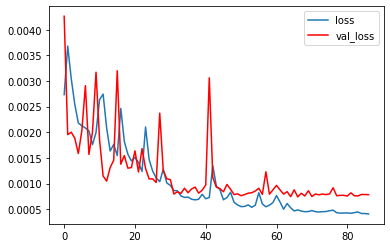

1
Truth.shape, Forecast.shape (721, 1) (721, 1)
Truth.shape, Forecast.shape (266, 1) (266, 1)


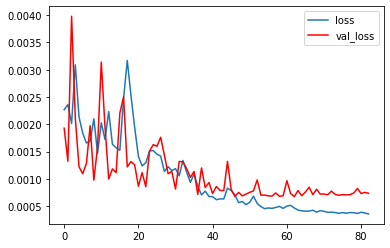

2
Truth.shape, Forecast.shape (721, 1) (721, 1)
Truth.shape, Forecast.shape (266, 1) (266, 1)


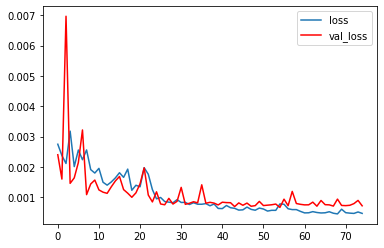

3
Truth.shape, Forecast.shape (721, 1) (721, 1)
Truth.shape, Forecast.shape (266, 1) (266, 1)


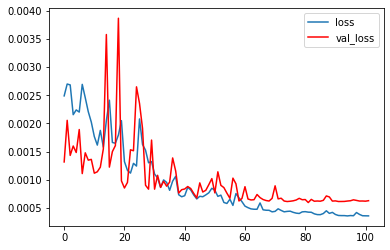

4
Truth.shape, Forecast.shape (721, 1) (721, 1)
Truth.shape, Forecast.shape (266, 1) (266, 1)


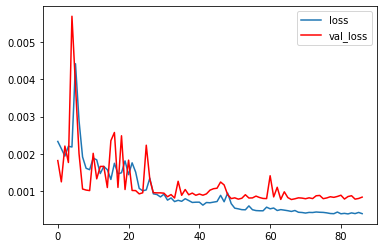

5
Truth.shape, Forecast.shape (721, 1) (721, 1)
Truth.shape, Forecast.shape (266, 1) (266, 1)


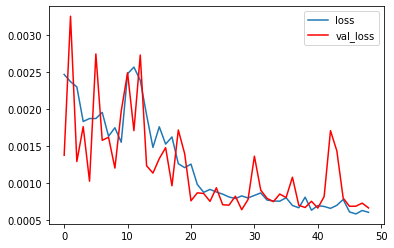

6
Truth.shape, Forecast.shape (721, 1) (721, 1)
Truth.shape, Forecast.shape (266, 1) (266, 1)


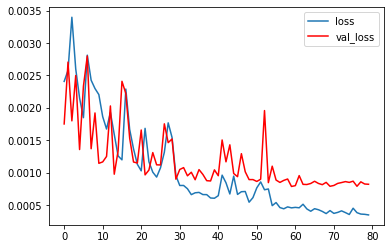

7
Truth.shape, Forecast.shape (721, 1) (721, 1)
Truth.shape, Forecast.shape (266, 1) (266, 1)


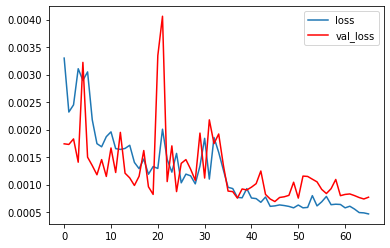

8
Truth.shape, Forecast.shape (721, 1) (721, 1)
Truth.shape, Forecast.shape (266, 1) (266, 1)


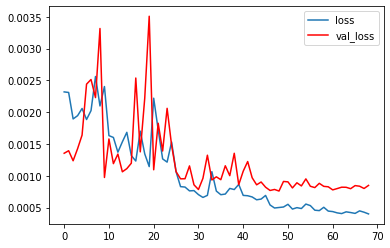

9
Truth.shape, Forecast.shape (721, 1) (721, 1)
Truth.shape, Forecast.shape (266, 1) (266, 1)


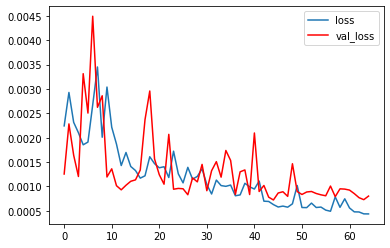

Wall time: 6min 10s


In [63]:
%%time
total_self = []
total_test = []
for i in range(10):
    print(i)
    model, modelResult = buildModel(X_train.shape, X_train, Y_train)
    self_predict, test_predict = evaluate_model(model, sc, SelfTruth, S_test, RawTrurh, X_test)
    total_self.append(np.reshape(self_predict, (self_predict.shape[0])))
    total_test.append(np.reshape(test_predict, (test_predict.shape[0])))
    plt.plot(modelResult.history['loss'][10:], label = 'loss')
    plt.plot(modelResult.history['val_loss'][10:], color = 'red', label = 'val_loss')
    plt.legend()
    plt.show()
mean_self = np.array(total_self).mean(axis=0)
mean_test = np.array(total_test).mean(axis=0)
# reshape
mean_self = np.reshape(mean_self, (mean_self.shape[0], 1))
mean_test = np.reshape(mean_test, (mean_test.shape[0], 1))

---
## Time

In [64]:
t = 1
save = True
# save = False
model_name = '(XT_RNN_2017_LR_Y)'

---
## Load Model

In [65]:
# # load
# from keras.models import load_model
# model = load_model('Model/industryElec_cLSTM(7to7)_model_0' + str(t) + '.h5')

---
## Self-Prediction

RMSE 3.6872558760021192
MAPE 0.8155012302645932


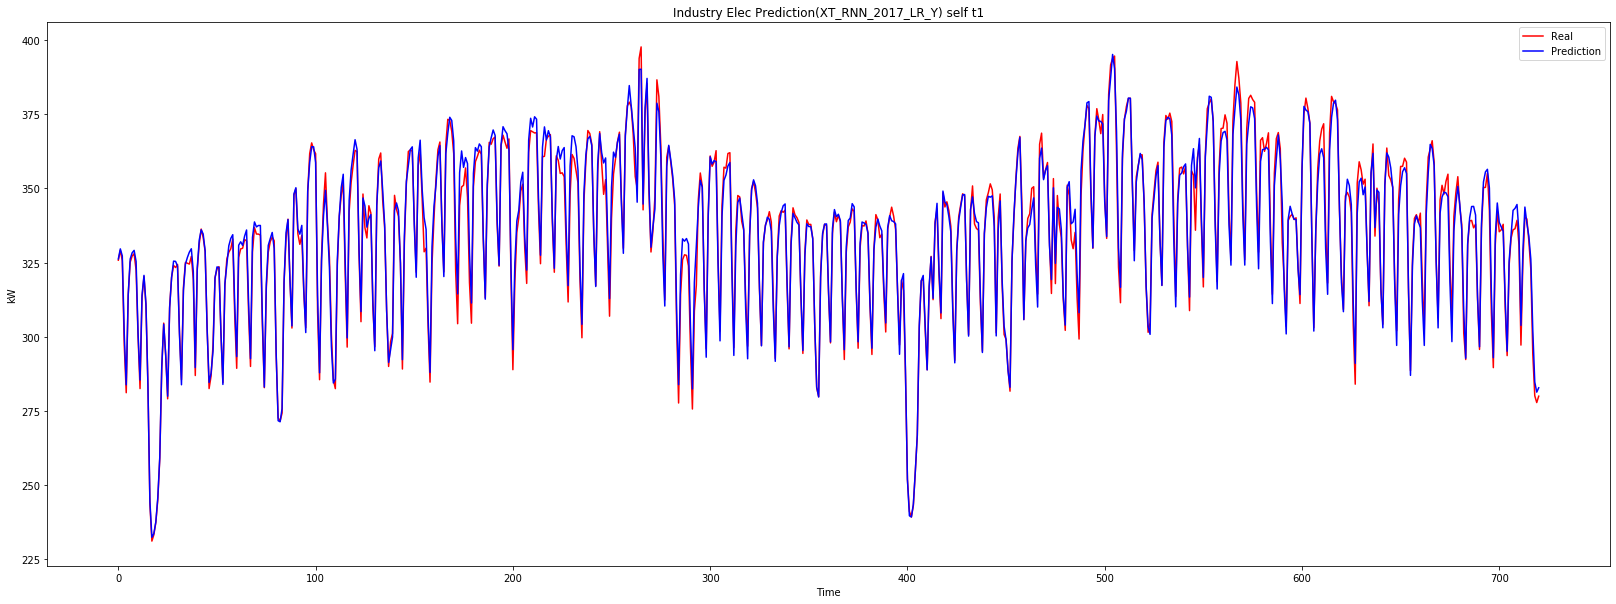

In [66]:
# 自我測試
self_trurh = pd.DataFrame(SelfTruth)
self_trurh = deNormalize(sc, self_trurh.values)
calcError(self_trurh, mean_self)
showPlot(self_trurh, mean_self, model_name , "self", size="L", save=save)

---
## Test-Prediction

In [67]:
date_range = pd.date_range(start = testFrom, end = testTo)

RMSE 8.782312263378332
MAPE 1.9705223046996196


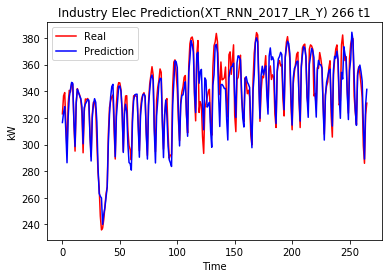

In [68]:
# 實際測試
test_trurh = pd.DataFrame(RawTrurh)
test_trurh = deNormalize(sc, test_trurh.values)
calcError(test_trurh, mean_test)
showPlot(test_trurh, mean_test, model_name , str(test_trurh.shape[0]), save=save)

---
## 替換特殊日

In [69]:
d = {'date': date_range, 
     'truth': np.reshape(test_trurh, (test_trurh.shape[0])),
     'rowsMean': np.reshape(mean_test, (mean_test.shape[0]))}
df_predictRange = pd.DataFrame(d)
df_predictRange.shape

(266, 3)

In [70]:
holiday_0202_0210 = (df_predictRange['date']>='2019-02-02') & (df_predictRange['date']<='2019-02-10')
holiday_0228_0303 = (df_predictRange['date']>='2019-02-28') & (df_predictRange['date']<='2019-03-03')
holiday_0404_0407 = (df_predictRange['date']>='2019-04-04') & (df_predictRange['date']<='2019-04-07')
holiday_0501 = (df_predictRange['date']>='2019-05-01') & (df_predictRange['date']<='2019-05-01')
holiday_0607_0609 = (df_predictRange['date']>='2019-06-07') & (df_predictRange['date']<='2019-06-09')
holiday_0913_0915 = (df_predictRange['date']>='2019-09-13') & (df_predictRange['date']<='2019-09-15')

df_update = df_predictRange
df_update.at[df_update[holiday_0202_0210].index.tolist(),'rowsMean']=[
    296.2685916606903,268.6551230596378,266.62611725019514,233.78048832652811,237.5939330392182,
    252.12632702508387,256.88761248559956,256.1430988708258,277.09936551484464]
df_update.at[df_update[holiday_0228_0303].index.tolist(),'rowsMean']=[
    315.53475376279357, 299.0515551307678, 279.6674245712996, 287.78825150981544]
df_update.at[df_update[holiday_0501].index.tolist(),'rowsMean']=[327.4281960201264]
df_update.at[df_update[holiday_0607_0609].index.tolist(),'rowsMean']=[
    356.92780619964606, 324.89612232303625, 319.65093342745297]
df_update.at[df_update[holiday_0913_0915].index.tolist(),'rowsMean']=[
    362.11747525558474, 323.0216351282596, 320.375536335349]

RMSE 8.858075499385283
MAPE 1.9669157431896414


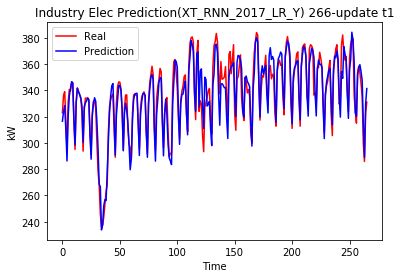

In [71]:
truth = df_update['truth']
pred = df_update['rowsMean']
calcError(truth, pred)
showPlot(truth, pred, model_name , str(truth.shape[0])+'-update', save=save)

In [72]:
ground_truth = go.Scatter(x=date_range, y=np.reshape(test_trurh, (test_trurh.shape[0])), name='truth')
predict_answer = go.Scatter(x=date_range, y=np.reshape(mean_test, (mean_test.shape[0])), name='predict')
layout = go.Layout(
    title = '預測值 vs 實際值',
    xaxis = dict(title = '日期'),
    yaxis = dict(title = '工業用電（百萬度）')
)
fig = go.Figure(data=[ground_truth, predict_answer], layout=layout)
iplot(fig)

In [73]:
ground_truth = go.Scatter(x=date_range, y=truth, name='truth')
predict_answer = go.Scatter(x=date_range, y=pred, name='predict')
layout = go.Layout(
    title = '預測值 vs 實際值',
    xaxis = dict(title = '日期'),
    yaxis = dict(title = '工業用電（百萬度）')
)
fig = go.Figure(data=[ground_truth, predict_answer], layout=layout)
iplot(fig)

---
## Save Model

In [74]:
# import h5py
# model.save('Model/IndustryElec_RNN(7to7)_XT_Best(1.96).h5')